In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='talk',
    # context='paper',
    # font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
print(np.__version__)
print(pd.__version__)

1.22.1
1.3.5


In [3]:
import nfp
print(nfp.__version__)

2022-05-23 16:23:53.345050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-05-23 16:23:53.345078: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


0.3.6


In [4]:
os.chdir('../')

In [5]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from scripts import ehull

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [6]:
# Dataframe containing competing phases from NRELMatDB
print("Reading inputs/competing_phases.csv")
df_competing_phases = pd.read_csv('inputs/competing_phases.csv')
print(f"\t{len(df_competing_phases)} lines")
print(df_competing_phases.head(2))

Reading inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4


In [7]:
df = pd.read_csv("/projects/rlmolecule/jlaw/crystal_outputs/2022-05-04/batt-icsd-volpred-KLiNa-no-halides-ScY/viz/pred_vs_dft.csv", index_col=0)
df.head(2)

,id,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy2
0,K1Sb1F6_sg148_icsd_015343_1,-4.636,0.00926,-4.608471,0.036789
1,Na1Hf1Hg1I7_sg9_icsd_060952_2,-2.820,0.04500,-2.620724,-0.001000


In [8]:
df['comp'] = df.id.apply(lambda x: x.split('_')[0])
df.head(2)

,id,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy2,comp
0,K1Sb1F6_sg148_icsd_015343_1,-4.636,0.00926,-4.608471,0.036789,K1Sb1F6
1,Na1Hf1Hg1I7_sg9_icsd_060952_2,-2.820,0.04500,-2.620724,-0.001000,Na1Hf1Hg1I7


In [9]:
def compute_decomp_energy(comp, energyperatom):
    decomp_energy = ehull.convex_hull_stability(comp,
                                                energyperatom,
                                                df_competing_phases)

    return decomp_energy

### Try to figure out what's going on for those points close to 0
A bunch of the points have a predicted decomposition energy = -0.001. 

For some reason, the DFT energy is less than the predicted energy, yet the DFT decomposition energy is > the predicted decomposition energy.

For one of the right-most points (Li1Al1Ge2S6_sg87_icsd_157854_2), the difference in energy per atom is really small, but the decomposition energy difference is big. I perturbed the DFT decomp energy around the original value to see if I could get it to flip

In [10]:
df['energyperatom_diff'] = (df['energyperatom'] - df['pred_energyperatom'])
df['decomp_energy_diff'] = (df['decomp_energy'] - df['pred_decomp_energy2'])

In [11]:
df[df.decomp_energy > 0.3] 

,id,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy2,comp,energyperatom_diff,decomp_energy_diff
23,K1Si1Cl2P1_sg188_icsd_009751_2,-3.704,0.565000,-3.147899,-0.001000,K1Si1Cl2P1,-0.556101,0.566000
39,Na2Y3S4N1_sg11_icsd_401745_1,-5.711,0.505000,-4.341964,-0.001000,Na2Y3S4N1,-1.369036,0.506000
43,Na1Sb1F1Cl5_sg51_icsd_079885_4,-2.895,0.411000,-2.039892,-0.001000,Na1Sb1F1Cl5,-0.855108,0.412000
57,Na2Hf1Zn1O4_sg123_icsd_092429_2,-5.463,0.743000,-3.819893,-0.001000,Na2Hf1Zn1O4,-1.643107,0.744000
59,Li1Al1Ge2S6_sg87_icsd_157854_2,-3.981,0.701000,-3.958867,-0.001000,Li1Al1Ge2S6,-0.022133,0.702000
64,Na3Sc1P2_sg141_icsd_067526_1,-3.716,0.313000,-3.469996,-0.001000,Na3Sc1P2,-0.246004,0.314000
75,Li1Sc2Zr2P5_sg55_icsd_040376_1,-5.937,0.537000,-5.005069,-0.001000,Li1Sc2Zr2P5,-0.931931,0.538000
79,Li1Cd2O1P1_sg2_icsd_171429_6,-3.467,0.313000,-2.966326,-0.001000,Li1Cd2O1P1,-0.500674,0.314000
97,K5Zn1S2P1_sg129_icsd_417278_1,-2.492,0.641000,-2.119674,-0.001000,K5Zn1S2P1,-0.372326,0.642000
118,Li1Zr1Hf1N3_sg15_icsd_249567_6,-7.985,0.339000,-6.955494,-0.001000,Li1Zr1Hf1N3,-1.029506,0.340000


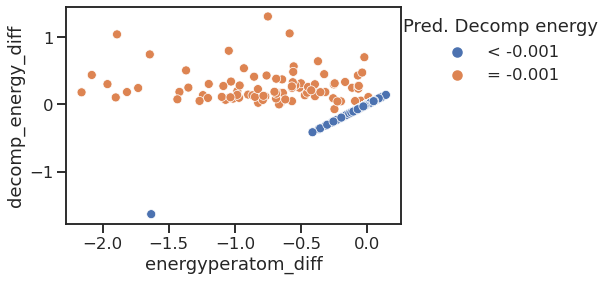

In [54]:
# f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4), sharey=True)
df['pred_decomp_energy_val'] = df['pred_decomp_energy2'].apply(
    lambda x: '= -0.001' if x == -0.001 else "< -0.001")
g = sns.scatterplot(data=df, x='energyperatom_diff', y='decomp_energy_diff',
            hue='pred_decomp_energy_val'
               )
g.legend(loc='center left', bbox_to_anchor=(.96, 0.8), ncol=1, title="Pred. Decomp energy")

# df[df.pred_decomp_energy2 == -0.001].plot.scatter(x='energyperatom_diff', y='decomp_energy_diff', ax=ax2)
# ax2.set_title("Pred. decomposition energy \n== -0.001")
# plt.tight_layout()
plt.show()
plt.close()

In [66]:
comps_to_test = [
    "Li1Al1Ge2S6_sg87_icsd_157854_2",
    "Na2Zr1Cd1I5P1_sg104_icsd_086200_3",
    # "K1Y1Si2O6_sg63_icsd_090908_1",
]

In [68]:
df[df.id.isin(comps_to_test)][['id', 'energyperatom', 'decomp_energy', 'pred_energyperatom', 'pred_decomp_energy2']]

,id,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy2
59,Li1Al1Ge2S6_sg87_icsd_157854_2,-3.981,0.701,-3.958867,-0.001
245,Na2Zr1Cd1I5P1_sg104_icsd_086200_3,-2.848,0.483,-2.288712,-0.001


In [56]:
# comp_to_test = "Li1Al1Ge2S6_sg87_icsd_157854_2"
comp_to_test = "Na2Zr1Cd1I5P1_sg104_icsd_086200_3"
df2 = df[df.id == comp_to_test]
df2.head()

,id,energyperatom,decomp_energy,pred_energyperatom,pred_decomp_energy2,comp,energyperatom_diff,decomp_energy_diff,pred_decomp_energy_val
245,Na2Zr1Cd1I5P1_sg104_icsd_086200_3,-2.848,0.483,-2.288712,-0.001,Na2Zr1Cd1I5P1,-0.559288,0.484,= -0.001


In [57]:
df2['decomp_energy_test'] = df2.apply(lambda row: compute_decomp_energy(row.comp, row.energyperatom), axis=1)
df2['decomp_energy_pred_test'] = df2.apply(lambda row: compute_decomp_energy(row.comp, row.pred_energyperatom), axis=1)
df2[['decomp_energy_test', 'decomp_energy_pred_test']]

stable = False switched: original_nrg =-0.6589999999999998 to B[index] =-1.142.
ii = 241, discrete_nrgs[ii] = -1.142, Hd =0.4830000000000001
stable = True switched: original_nrg =-0.10000000000000009 to B[index] =-0.09900000000000009.
ii = 0, discrete_nrgs[ii] = -0.09900000000000009, Hd =-0.0010000000000000009


/tmp/ipykernel_20760/1012581995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['decomp_energy_test'] = df2.apply(lambda row: compute_decomp_energy(row.comp, row.energyperatom), axis=1)
/tmp/ipykernel_20760/1012581995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['decomp_energy_pred_test'] = df2.apply(lambda row: compute_decomp_energy(row.comp, row.pred_energyperatom), axis=1)


,decomp_energy_test,decomp_energy_pred_test
245,0.483,-0.001


In [58]:
comp, pred_energyperatom = df2[['comp', 'pred_energyperatom']].values[0]
(comp, pred_energyperatom)

('Na2Zr1Cd1I5P1', -2.2887122631073)

In [59]:
decomp_energies = []

# try many points around the predicted energyperatom
for ediff in tqdm(np.arange(-.4, .46, .05)):
    decomp_energy = compute_decomp_energy(comp, pred_energyperatom + ediff)
    decomp_energies.append((pred_energyperatom + ediff, decomp_energy))
    # print(ediff, decomp_energy)

for ediff in tqdm(np.arange(-.12, .13, .01)):
    decomp_energy = compute_decomp_energy(comp, pred_energyperatom + ediff)
    decomp_energies.append((pred_energyperatom + ediff, decomp_energy))
    # print(ediff, decomp_energy)

  0%|          | 0/18 [00:00<?, ?it/s]

stable = True switched: original_nrg =-0.5 to B[index] =-0.499.
ii = 0, discrete_nrgs[ii] = -0.499, Hd =-0.0010000000000000009
stable = False switched: original_nrg =-0.44999999999999973 to B[index] =-1.1409999999999998.
ii = 345, discrete_nrgs[ii] = -1.1409999999999998, Hd =0.6910000000000001
stable = False switched: original_nrg =-0.3999999999999999 to B[index] =-1.141.
ii = 370, discrete_nrgs[ii] = -1.141, Hd =0.7410000000000001
stable = False switched: original_nrg =-0.3500000000000001 to B[index] =-1.141.
ii = 395, discrete_nrgs[ii] = -1.141, Hd =0.7909999999999999
stable = False switched: original_nrg =-0.2999999999999998 to B[index] =-1.1409999999999998.
ii = 420, discrete_nrgs[ii] = -1.1409999999999998, Hd =0.841
stable = False switched: original_nrg =-0.25 to B[index] =-1.141.
ii = 445, discrete_nrgs[ii] = -1.141, Hd =0.891
stable = True switched: original_nrg =-0.19999999999999973 to B[index] =-0.19899999999999973.
ii = 0, discrete_nrgs[ii] = -0.19899999999999973, Hd =-0.0010

  0%|          | 0/25 [00:00<?, ?it/s]

stable = False switched: original_nrg =-0.21999999999999975 to B[index] =-1.1409999999999998.
ii = 460, discrete_nrgs[ii] = -1.1409999999999998, Hd =0.921
stable = False switched: original_nrg =-0.20999999999999996 to B[index] =-1.141.
ii = 465, discrete_nrgs[ii] = -1.141, Hd =0.931
stable = True switched: original_nrg =-0.19999999999999973 to B[index] =-0.19899999999999973.
ii = 0, discrete_nrgs[ii] = -0.19899999999999973, Hd =-0.0010000000000000009
stable = False switched: original_nrg =-0.18999999999999995 to B[index] =-1.141.
ii = 475, discrete_nrgs[ii] = -1.141, Hd =0.9510000000000001
stable = False switched: original_nrg =-0.18000000000000016 to B[index] =-1.141.
ii = 480, discrete_nrgs[ii] = -1.141, Hd =0.9609999999999999
stable = False switched: original_nrg =-0.16999999999999993 to B[index] =-1.141.
ii = 485, discrete_nrgs[ii] = -1.141, Hd =0.9710000000000001
stable = False switched: original_nrg =-0.16000000000000014 to B[index] =-1.141.
ii = 490, discrete_nrgs[ii] = -1.141, 

In [63]:
df_test = pd.DataFrame(decomp_energies, columns=['energyperatom', 'decomp_energy'])
df_test.head(2)

,energyperatom,decomp_energy
0,-2.688712,-0.001
1,-2.638712,0.691


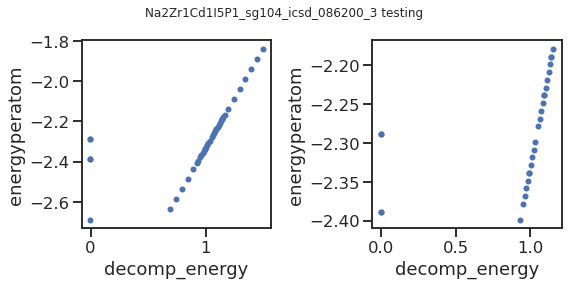

In [65]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
df_test.plot.scatter(x="decomp_energy", y="energyperatom", ax=ax1)
df_test2 = df_test[(df_test.energyperatom > pred_energyperatom - .12) & 
                   (df_test.energyperatom < pred_energyperatom + .12)]
df_test2.plot.scatter(x="decomp_energy", y="energyperatom", ax=ax2)
plt.suptitle(f"{comp_to_test} testing")
plt.tight_layout()

In [55]:
df_test2.sort_values('energyperatom')

,energyperatom,decomp_energy
26,-4.068867,0.613
8,-4.058867,0.623
27,-4.058867,0.623
28,-4.048867,0.633
29,-4.038867,0.643
30,-4.028867,0.653
31,-4.018867,0.663
9,-4.008867,0.673
32,-4.008867,0.673
33,-3.998867,0.683
